# **Basic setup**

In [1]:
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from pathlib import Path
import nltk
import json
import pickle
from sklearn.model_selection import train_test_split 
from collections import defaultdict,Counter

In [2]:
traces_filename = "overall-pos_neg_final-dataset.json"

In [3]:
with open(traces_filename) as trace_file:
  json_traces = json.load(trace_file)

df = pd.DataFrame(json_traces)

In [4]:
df

,snippet,intent,question_id,class,clean_snippet,cleaned_intent
0,from bs4 import BeautifulSoup\nimport json\nso...,how to grab from JSON in selenium python,26661808.0,1,"[from, <VAR_NAME>, import, <VAR_NAME>, import,...",how to grab from json in selenium python
1,"np.fromfunction(f, shape=(d1, d2))",Fastest way to initialize numpy array with val...,31719440.0,1,"[np, ., fromfunction, (, <VAR_NAME>, ,, shape,...",fastest way to initialize numpy array with val...
2,buildbot sendchange --master {MASTERHOST}:{POR...,Buildbot force build via python,18874387.0,1,"[<VAR_NAME>, <VAR_NAME>, -, -, <VAR_NAME>, {, ...",buildbot force build via python
3,import time\ntime.gmtime(0),What is the oldest time that can be represente...,1310740.0,1,"[import, time, time, ., gmtime, (, 0, )]",what is the oldest time that can be represente...
4,"re.sub(re.compile('^\n', re.MULTILINE), '', s)",Sublime Text 3 API plugin for regex replacing ...,36831257.0,1,"[re, ., sub, (, re, ., compile, (, '^\n', ,, r...",sublime text 3 api plugin for regex replacing ...
...,...,...,...,...,...,...
85155,"'%4f %s' % (5, myobj.str('<'))",how to determine an integer in a string list,NaN,0,"['%4f %s', %, (, 5, ,, <VAR_NAME>, ., str, (, ...",how to determine an integer in a string list
85156,f = lambda line: float(line.split()[0])\nwith ...,Cut a large text file in small files,NaN,0,"[<VAR_NAME>, =, lambda, <VAR_NAME>, :, float, ...",cut a large text file in small files
85157,"prop = property(memoized(prop.fget), prop.fset...",How to add and serialise additional fields of ...,NaN,0,"[<VAR_NAME>, =, property, (, <VAR_NAME>, (, <V...",how to add and serialise additional fields of ...
85158,datetime TEXT UNIQUE,Python: most efficient way to convert date to ...,NaN,0,"[datetime, <VAR_NAME>, <VAR_NAME>]",python most efficient way to convert date to d...


# **TRAIN-TEST-VAL Split**

In [5]:
df_train_all,df_test = train_test_split(df,test_size = 0.2,random_state = 999)
print(len(df_train_all))
print(len(df_test))

68128
17032


80-20 Train-test split
and then last 10% of train is used as val

In [6]:
df_train = df_train_all.iloc[:-int(0.1*68128),:]
df_val = df_train_all.iloc[-int(0.1*68128):,:]
print(len(df_train))
print(len(df_val))

61316
6812


In [7]:
df_train['class'].value_counts()

1    30987
0    30329
Name: class, dtype: int64

In [8]:
df_val['class'].value_counts()

1    3476
0    3336
Name: class, dtype: int64

In [9]:
df_test['class'].value_counts()

1    8775
0    8257
Name: class, dtype: int64

# **Custom tokenizer**

In [10]:
input_decoder_snippets = df['clean_snippet'].apply(lambda snippet: ["<START>"] + snippet).values.tolist()
output_decoder_snippets = df['clean_snippet'].apply(lambda snippet: snippet + ["<END>"]).values.tolist()
print(input_decoder_snippets[:4])
print(output_decoder_snippets[:4])

[['<START>', 'from', '<VAR_NAME>', 'import', '<VAR_NAME>', 'import', 'json', '<VAR_NAME>', '=', '<VAR_NAME>', '(', '<VAR_NAME>', '.', '<VAR_NAME>', ')', '<VAR_NAME>', '=', 'json', '.', 'loads', '(', '<VAR_NAME>', '.', 'find', '(', '"body"', ')', '.', 'text', ')'], ['<START>', 'np', '.', 'fromfunction', '(', '<VAR_NAME>', ',', 'shape', '=', '(', '<VAR_NAME>', ',', '<VAR_NAME>', ')', ')'], ['<START>', '<VAR_NAME>', '<VAR_NAME>', '-', '-', '<VAR_NAME>', '{', '<VAR_NAME>', '}', ':', '{', '<VAR_NAME>', '}', '-', '-', '<VAR_NAME>', '{', '<VAR_NAME>', '}', ':', '{', '<VAR_NAME>', '}', '-', '-', 'who', '{', '<VAR_NAME>', '}', '{', '<VAR_NAME>', '.', '.', '}'], ['<START>', 'import', 'time', 'time', '.', 'gmtime', '(', '0', ')']]
[['from', '<VAR_NAME>', 'import', '<VAR_NAME>', 'import', 'json', '<VAR_NAME>', '=', '<VAR_NAME>', '(', '<VAR_NAME>', '.', '<VAR_NAME>', ')', '<VAR_NAME>', '=', 'json', '.', 'loads', '(', '<VAR_NAME>', '.', 'find', '(', '"body"', ')', '.', 'text', ')', '<END>'], ['np', 

In [11]:
vocab = []
for tokens in input_decoder_snippets + output_decoder_snippets:
  for token in tokens:
    vocab.append(token)

print(len(set(vocab)))

36211


In [12]:
word_counts = dict(Counter(vocab))
wcounts = list(word_counts.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
wcounts[:15]

[('<VAR_NAME>', 920328),
 (')', 373152),
 ('(', 373142),
 (',', 304440),
 ('.', 300666),
 ('=', 201174),
 ('[', 129664),
 (']', 129660),
 (':', 115042),
 ('<START>', 85160),
 ('<END>', 85160),
 ('in', 49650),
 ('1', 46500),
 ('for', 44288),
 ('import', 39318)]

In [13]:
sorted_voc = []
sorted_voc.extend(wc[0] for wc in wcounts)

In [14]:
word_index = dict(zip(sorted_voc, list(range(1, len(sorted_voc) + 1))))
list(word_index.items())[:15]

[('<VAR_NAME>', 1),
 (')', 2),
 ('(', 3),
 (',', 4),
 ('.', 5),
 ('=', 6),
 ('[', 7),
 (']', 8),
 (':', 9),
 ('<START>', 10),
 ('<END>', 11),
 ('in', 12),
 ('1', 13),
 ('for', 14),
 ('import', 15)]

In [15]:
len(word_index) + 1

36212

In [16]:
def text2seq(snippets,w2i = word_index):
  sequences = []
  for tokens in snippets:
    seq = []
    for token in tokens:
      seq.append(w2i[token])
  
    sequences.append(seq)
  
  return sequences

# **Tokenize the intent and the snippets**

Reference: https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/

In [17]:
tok_intent = Tokenizer()

In [18]:
input_encoder_intents = df['cleaned_intent'].values.tolist()
print(input_encoder_intents[:4])

['how to grab from json in selenium python', 'fastest way to initialize numpy array with values given by function', 'buildbot force build via python', 'what is the oldest time that can be represented in python']


In [19]:
tok_intent.fit_on_texts(input_encoder_intents)

In [20]:
# summarize what was learned
print(tok_intent.word_counts)
print(tok_intent.document_count)
print(tok_intent.word_index)
print(tok_intent.word_docs)

OrderedDict([('how', 20864), ('to', 32600), ('grab', 93), ('from', 9865), ('json', 772), ('in', 33959), ('selenium', 582), ('python', 38047), ('fastest', 159), ('way', 3015), ('initialize', 79), ('numpy', 2816), ('array', 3500), ('with', 10220), ('values', 3199), ('given', 586), ('by', 2921), ('function', 2935), ('buildbot', 4), ('force', 136), ('build', 194), ('via', 396), ('what', 1223), ('is', 4967), ('the', 12784), ('oldest', 4), ('time', 1255), ('that', 1839), ('can', 3528), ('be', 568), ('represented', 20), ('sublime', 30), ('text', 2119), ('3', 1285), ('api', 376), ('plugin', 44), ('for', 5718), ('regex', 2049), ('replacing', 236), ('when', 1650), ('i', 6508), ('download', 222), ('an', 4144), ('ipython', 416), ('notebook', 186), ('as', 2158), ('a', 35052), ('pdf', 137), ('which', 669), ('font', 75), ('does', 1054), ('it', 1692), ('use', 1964), ('why', 840), ('0x7fffffff', 2), ('31', 4), ('1', 725), ('zero', 144), ('run', 869), ('program', 558), ('linux', 276), ('crontab', 18), (

In [21]:
with open("tok-intent.pkl",'wb') as f:
  pickle.dump(tok_intent,f)

with open("tok-snippet.pkl",'wb') as f:
  pickle.dump(word_index,f)

In [22]:
input_decoder_snippets = df['clean_snippet'].apply(lambda snippet: ["<START>"] + snippet).values.tolist()
output_decoder_snippets = df['clean_snippet'].apply(lambda snippet: snippet + ["<END>"]).values.tolist()

In [23]:
print(input_decoder_snippets[:4])
print(output_decoder_snippets[:4])

[['<START>', 'from', '<VAR_NAME>', 'import', '<VAR_NAME>', 'import', 'json', '<VAR_NAME>', '=', '<VAR_NAME>', '(', '<VAR_NAME>', '.', '<VAR_NAME>', ')', '<VAR_NAME>', '=', 'json', '.', 'loads', '(', '<VAR_NAME>', '.', 'find', '(', '"body"', ')', '.', 'text', ')'], ['<START>', 'np', '.', 'fromfunction', '(', '<VAR_NAME>', ',', 'shape', '=', '(', '<VAR_NAME>', ',', '<VAR_NAME>', ')', ')'], ['<START>', '<VAR_NAME>', '<VAR_NAME>', '-', '-', '<VAR_NAME>', '{', '<VAR_NAME>', '}', ':', '{', '<VAR_NAME>', '}', '-', '-', '<VAR_NAME>', '{', '<VAR_NAME>', '}', ':', '{', '<VAR_NAME>', '}', '-', '-', 'who', '{', '<VAR_NAME>', '}', '{', '<VAR_NAME>', '.', '.', '}'], ['<START>', 'import', 'time', 'time', '.', 'gmtime', '(', '0', ')']]
[['from', '<VAR_NAME>', 'import', '<VAR_NAME>', 'import', 'json', '<VAR_NAME>', '=', '<VAR_NAME>', '(', '<VAR_NAME>', '.', '<VAR_NAME>', ')', '<VAR_NAME>', '=', 'json', '.', 'loads', '(', '<VAR_NAME>', '.', 'find', '(', '"body"', ')', '.', 'text', ')', '<END>'], ['np', 

In [24]:
train_intent_sequences = tok_intent.texts_to_sequences(df_train['cleaned_intent'].values.tolist())
test_intent_sequences = tok_intent.texts_to_sequences(df_test['cleaned_intent'].values.tolist())
val_intent_sequences = tok_intent.texts_to_sequences(df_val['cleaned_intent'].values.tolist())

In [25]:
train_input_snippet_sequences = text2seq(df_train['clean_snippet'].apply(lambda snippet: ["<START>"] + snippet).values.tolist())
test_input_snippet_sequences = text2seq(df_test['clean_snippet'].apply(lambda snippet: ["<START>"] + snippet).values.tolist())
val_input_snippet_sequences = text2seq(df_val['clean_snippet'].apply(lambda snippet: ["<START>"] + snippet).values.tolist())

In [26]:
train_output_snippet_sequences = text2seq(df_train['clean_snippet'].apply(lambda snippet: snippet + ["<END>"]).values.tolist())
test_output_snippet_sequences = text2seq(df_test['clean_snippet'].apply(lambda snippet: snippet + ["<END>"]).values.tolist())
val_output_snippet_sequences = text2seq(df_val['clean_snippet'].apply(lambda snippet: snippet + ["<END>"]).values.tolist())

In [27]:
print(len(train_input_snippet_sequences),len(test_input_snippet_sequences),len(val_input_snippet_sequences))

61316 17032 6812


In [28]:
print(len(train_intent_sequences),len(test_intent_sequences),len(val_intent_sequences))

61316 17032 6812


In [29]:
print(len(train_output_snippet_sequences),len(test_output_snippet_sequences),len(val_output_snippet_sequences))

61316 17032 6812


In [30]:
train_intent_sequences[0]

[513, 2, 66, 49, 6, 73, 13, 1]

In [31]:
train_input_snippet_sequences[0]

[10,
 1,
 6,
 1,
 3,
 1,
 2,
 1,
 5,
 1,
 5,
 339,
 3,
 1,
 6,
 17,
 4,
 1,
 6,
 17,
 2,
 1,
 5,
 1,
 5,
 339,
 3,
 1,
 6,
 17,
 4,
 1,
 6,
 13,
 2,
 1,
 5,
 1,
 5,
 339,
 3,
 1,
 6,
 17,
 4,
 1,
 6,
 19,
 2,
 1,
 5,
 339,
 3,
 1,
 6,
 33,
 4,
 1,
 6,
 17,
 2]

In [32]:
train_output_snippet_sequences[0]

[1,
 6,
 1,
 3,
 1,
 2,
 1,
 5,
 1,
 5,
 339,
 3,
 1,
 6,
 17,
 4,
 1,
 6,
 17,
 2,
 1,
 5,
 1,
 5,
 339,
 3,
 1,
 6,
 17,
 4,
 1,
 6,
 13,
 2,
 1,
 5,
 1,
 5,
 339,
 3,
 1,
 6,
 17,
 4,
 1,
 6,
 19,
 2,
 1,
 5,
 339,
 3,
 1,
 6,
 33,
 4,
 1,
 6,
 17,
 2,
 11]

In [33]:
all_intent_seq = train_intent_sequences + test_intent_sequences + val_intent_sequences
all_input_snippet_seq = train_input_snippet_sequences + test_input_snippet_sequences + val_input_snippet_sequences
all_output_snippet_seq = train_output_snippet_sequences + test_output_snippet_sequences + val_output_snippet_sequences
print(len(all_intent_seq))
print(len(all_input_snippet_seq))
print(len(all_output_snippet_seq))

85160
85160
85160


In [34]:
all_snippet_seq = all_input_snippet_seq + all_output_snippet_seq

In [35]:
maxlen_intent = max([len(x) for x in all_intent_seq])
maxlen_snippet = max([len(x) for x in all_snippet_seq])
print(maxlen_intent)
print(maxlen_snippet)

35
635


In [36]:
pad_length_intent = 35
pad_length_snippet = 635

#**GET THE ENCODER-DECODER INPUTS**

In [37]:
#encoder as prepadding the tokens
train_padded_intent_sequences = pad_sequences(train_intent_sequences,maxlen = pad_length_intent,padding= 'pre')
test_padded_intent_sequences = pad_sequences(test_intent_sequences,maxlen = pad_length_intent,padding= 'pre')
val_padded_intent_sequences = pad_sequences(val_intent_sequences,maxlen = pad_length_intent,padding= 'pre')

In [38]:
train_padded_intent_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 513,   2,  66,  49,   6,  73,  13,   1], dtype=int32)

In [39]:
#decoder input as post padding the tokens
train_padded_input_snippet_sequences = pad_sequences(train_input_snippet_sequences,maxlen = pad_length_snippet,padding= 'post')
test_padded_input_snippet_sequences = pad_sequences(test_input_snippet_sequences,maxlen = pad_length_snippet,padding= 'post')
val_padded_input_snippet_sequences = pad_sequences(val_input_snippet_sequences,maxlen = pad_length_snippet,padding= 'post')

In [40]:
train_padded_input_snippet_sequences[0]

array([ 10,   1,   6,   1,   3,   1,   2,   1,   5,   1,   5, 339,   3,
         1,   6,  17,   4,   1,   6,  17,   2,   1,   5,   1,   5, 339,
         3,   1,   6,  17,   4,   1,   6,  13,   2,   1,   5,   1,   5,
       339,   3,   1,   6,  17,   4,   1,   6,  19,   2,   1,   5, 339,
         3,   1,   6,  33,   4,   1,   6,  17,   2,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [41]:
#decoder output as post padding the tokens
train_padded_output_snippet_sequences = pad_sequences(train_output_snippet_sequences,maxlen = pad_length_snippet,padding= 'post')
test_padded_output_snippet_sequences = pad_sequences(test_output_snippet_sequences,maxlen = pad_length_snippet,padding= 'post')
val_padded_output_snippet_sequences = pad_sequences(val_output_snippet_sequences,maxlen = pad_length_snippet,padding= 'post')

In [42]:
train_padded_output_snippet_sequences[0]

array([  1,   6,   1,   3,   1,   2,   1,   5,   1,   5, 339,   3,   1,
         6,  17,   4,   1,   6,  17,   2,   1,   5,   1,   5, 339,   3,
         1,   6,  17,   4,   1,   6,  13,   2,   1,   5,   1,   5, 339,
         3,   1,   6,  17,   4,   1,   6,  19,   2,   1,   5, 339,   3,
         1,   6,  33,   4,   1,   6,  17,   2,  11,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [43]:
y_train = df_train['class'].values.tolist()
y_test = df_test['class'].values.tolist()
y_val = df_val['class'].values.tolist()

# **Load the embeddings pretrained**

In [44]:
print("ENCODER INPUT INTENTS")
print(len(train_padded_intent_sequences))
print(len(test_padded_intent_sequences))
print(len(val_padded_intent_sequences))
print("The single sequence intent's length after padding")
print(len(train_padded_intent_sequences[0]))
print(len(test_padded_intent_sequences[0]))
print(len(val_padded_intent_sequences[0]))

ENCODER INPUT INTENTS
61316
17032
6812
The single sequence intent's length after padding
35
35
35


In [45]:
print("DECODER INPUT INTENTS")
print(len(train_padded_input_snippet_sequences))
print(len(test_padded_input_snippet_sequences))
print(len(val_padded_input_snippet_sequences))
print("The single sequence input snippet's length after padding")
print(len(train_padded_input_snippet_sequences[0]))
print(len(test_padded_input_snippet_sequences[0]))
print(len(val_padded_input_snippet_sequences[0]))

DECODER INPUT INTENTS
61316
17032
6812
The single sequence input snippet's length after padding
635
635
635


In [46]:
print("DECODER OUTPUT INTENTS")
print(len(train_padded_output_snippet_sequences))
print(len(test_padded_output_snippet_sequences))
print(len(val_padded_output_snippet_sequences))
print("The single sequence output snippet's length after padding")
print(len(train_padded_output_snippet_sequences[0]))
print(len(test_padded_output_snippet_sequences[0]))
print(len(val_padded_output_snippet_sequences[0]))

DECODER OUTPUT INTENTS
61316
17032
6812
The single sequence output snippet's length after padding
635
635
635


In [47]:
print(len(y_train))
print(len(y_test))
print(len(y_val))

61316
17032
6812


In [48]:
NUM_TRAIN = 61316
NUM_TEST = 17032
NUM_VAL = 6812

In [49]:
IN_LSTM_NODES = 100
OUT_LSTM_NODES = 100
EMBEDDING_SIZE = 100

## **Intents**

In [50]:
#load W2V vectors from the pretrained intent embeddings
model_filename = 'intents-w2v.model'
w2v_embedding = KeyedVectors.load(model_filename) 
w2v_embedding

In [51]:
w2v_embedding.get_vector("how")

array([ 0.422673  ,  0.02139586, -0.31982917,  0.30531353, -0.10163563,
       -0.30285385, -0.40589935,  0.061556  , -0.12229313, -0.7068384 ,
        0.4235989 ,  0.06133464,  0.12010261,  0.42808372, -0.72650063,
       -0.06440832,  0.32755166,  0.23812793, -0.39608184, -0.35161206,
        0.52922356,  0.5480077 , -0.47754827,  0.11896577, -0.40553978,
       -0.17735755,  0.09741168, -0.12000675, -0.59936213,  0.47911087,
        0.02638219, -0.30764163,  0.32888344,  0.16819696,  0.24176408,
       -0.05385845, -0.50810766, -0.02387948,  0.3089714 ,  0.00224981,
        0.13656402,  0.3651695 , -0.01589961,  0.27675295,  0.79513425,
       -0.00468351, -0.28871778,  0.27303654, -0.14033532, -0.6798763 ,
        0.28056386, -0.37281886,  0.27257156, -0.17961681,  0.29339638,
       -0.13684915,  0.07527405, -0.27632105, -0.09597389, -0.5720295 ,
        0.28201225,  0.2949312 , -0.34197953,  0.3878542 , -0.24812742,
        0.2752094 , -0.02644131, -0.1574601 , -0.3339567 ,  0.63

In [52]:
word2idx_inputs = tok_intent.word_index 
len(word2idx_inputs)

13795

In [53]:
num_words_intent = len(word2idx_inputs) + 1
print(num_words_intent)

13796


In [54]:
embedding_matrix = np.zeros((num_words_intent, EMBEDDING_SIZE))
how_many_non_vocab = 0
for word, index in word2idx_inputs.items():
  try:
    embedding_vector = w2v_embedding.get_vector(word)
  except KeyError:
    embedding_vector = np.zeros((EMBEDDING_SIZE))
    how_many_non_vocab += 1
  
  embedding_matrix[index] = embedding_vector

In [55]:
how_many_non_vocab

1177

In [56]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.42368132,  0.03671886, -0.0567421 , ..., -0.10083763,
        -0.20472552, -0.31132799],
       [ 0.3888371 ,  0.3104842 , -0.28249851, ..., -0.11646538,
        -0.21428129, -0.42450696],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17449893,  0.078116  , -0.11979459, ...,  0.17875296,
        -0.10433522, -0.15421274],
       [ 0.36333618,  0.17967218, -0.28173149, ..., -0.08367095,
        -0.15235136, -0.24928749]])

## **Code Snippet (TO UPDATE for each MODEL (1-4))**

In [57]:
num_words_output = len(word_index) + 1
num_words_output

36212

In [58]:
p = str(Path.cwd())
glove_f_co = datapath(p + '/combined-glove-vectors-mincount0.txt')
tmp_f_co = get_tmpfile(p + '/combined-glove-vectors-as-w2v.txt')
_ = glove2word2vec(glove_f_co, tmp_f_co)
co_model_g = KeyedVectors.load_word2vec_format(tmp_f_co) 

In [59]:
word2idx_outputs = word_index

In [60]:
len(co_model_g.wv.vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


39106

In [ ]:
del code_embedding_matrix

In [62]:
code_embedding_matrix = np.zeros((num_words_output, EMBEDDING_SIZE))
how_many_non_vocab = 0
words = []
for word, index in word2idx_outputs.items():
  try:
    embedding_vector = co_model_g.get_vector(word)
  except KeyError:
    embedding_vector = np.zeros((EMBEDDING_SIZE))
    how_many_non_vocab += 1
    words.append(word)
    
  
  code_embedding_matrix[index] = embedding_vector

In [63]:
how_many_non_vocab

25472

In [64]:
words[:25]

['<START>',
 '<END>',
 "''",
 "'a'",
 ' ',
 "'b'",
 "' '",
 "'c'",
 "','",
 "'w'",
 "'\\n'",
 "'r'",
 "'name'",
 "'d'",
 "'A'",
 "'1'",
 "'.'",
 "'foo'",
 "'id'",
 "'x'",
 '" "',
 "'",
 "'bar'",
 "'B'",
 "'utf-8'"]

# **MODELLING (BASE)**

##  **Seq2Seq Modelling**

Reference: https://github.com/samurainote/seq2seq_translate_slackbot/blob/master/seq2seq_translate.py

In [65]:

"""
Encoder Architecture
"""

encoder_inputs = Input(shape=(pad_length_intent,))

#Our addition starts
embedding_layer = Embedding(num_words_intent, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=pad_length_intent)
intent_sequence_w2v = embedding_layer(encoder_inputs)
#Our addition ends

encoder_lstm = LSTM(units=IN_LSTM_NODES, return_state=True, return_sequences=False)
# x-axis: time-step lstm
encoder_outputs, state_h, state_c = encoder_lstm(intent_sequence_w2v)
encoder_states = [state_h, state_c] # We discard `encoder_outputs` and only keep the states.

"""
Decoder Architecture
"""
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.

decoder_inputs = Input(shape = (pad_length_snippet,))
code_embedding_layer = Embedding(num_words_output,EMBEDDING_SIZE,weights = [code_embedding_matrix],input_length=pad_length_snippet)
decoder_inputs_embed = code_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(units=OUT_LSTM_NODES, return_sequences=True, return_state=True)
# x-axis: time-step lstm
decoder_outputs, de_state_h, de_state_c = decoder_lstm(decoder_inputs_embed,initial_state = encoder_states) #decoder_lstm(decoder_inputs, initial_state=encoder_states) # Set up the decoder, using `encoder_states` as initial state.
decoder_softmax_layer = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

"""
Encoder-Decoder Architecture
"""
# Define the model that will turn, `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="Adam", loss="categorical_crossentropy",metrics = ['accuracy']) # Set up model

In [66]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 635)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 100)      1379600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 635, 100)     3621200     input_2[0][0]                    
_______________________________________________________________________________________

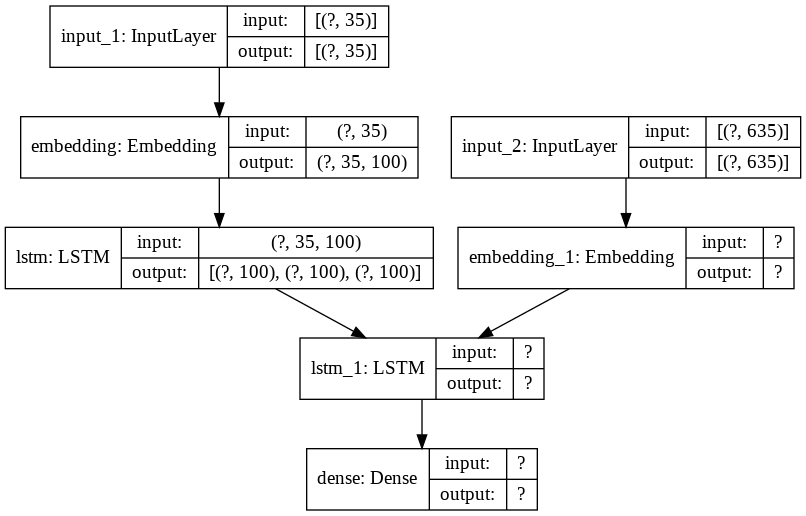

In [75]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True,to_file="seq2seqmodel.png")

In [68]:
#INFERENCE SET UP
# inputs=encoder_inputs, outputs=encoder_states
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 35)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 35, 100)           1379600   
_________________________________________________________________
lstm (LSTM)                  [(None, 100), (None, 100) 80400     
Total params: 1,460,000
Trainable params: 1,460,000
Non-trainable params: 0
_________________________________________________________________


In [69]:
# State from encoder
decoder_state_input_h = Input(shape=(OUT_LSTM_NODES,))
decoder_state_input_c = Input(shape=(OUT_LSTM_NODES,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = code_embedding_layer(decoder_inputs_single)

# x-axis: time-step lstm
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_state_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)

decoder_model = Model(inputs=[decoder_inputs_single] + decoder_state_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             3621200     input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
_______________________________________________________________________________________

In [70]:
print(decoder_state_input_c.shape)
print(decoder_state_input_h.shape)

(None, 100)
(None, 100)


## **Binary Classifier**

In [71]:
drop_rate = 0.5

In [72]:
intent_input = Input(EMBEDDING_SIZE,)
code_sequence = Input(EMBEDDING_SIZE,)

concat_input = keras.layers.Concatenate(axis=1)([intent_input,code_sequence])
hidden1 = Dense(100,activation="relu")(concat_input)
drop1 = keras.layers.Dropout(drop_rate)(hidden1)
hidden2 = Dense(50,activation="relu")(drop1)
drop2 = keras.layers.Dropout(drop_rate)(hidden2)
hidden3 = Dense(25,activation="relu")(drop2)
drop3 = keras.layers.Dropout(drop_rate)(hidden2)
output_layer = Dense(1,activation="sigmoid")(drop3)

binary_model = Model(inputs = [intent_input,code_sequence],outputs = [output_layer])
binary_model.compile(loss = 'binary_crossentropy',metrics = ['accuracy'],optimizer = "Adam")

In [73]:
binary_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 200)          0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          20100       concatenate[0][0]     

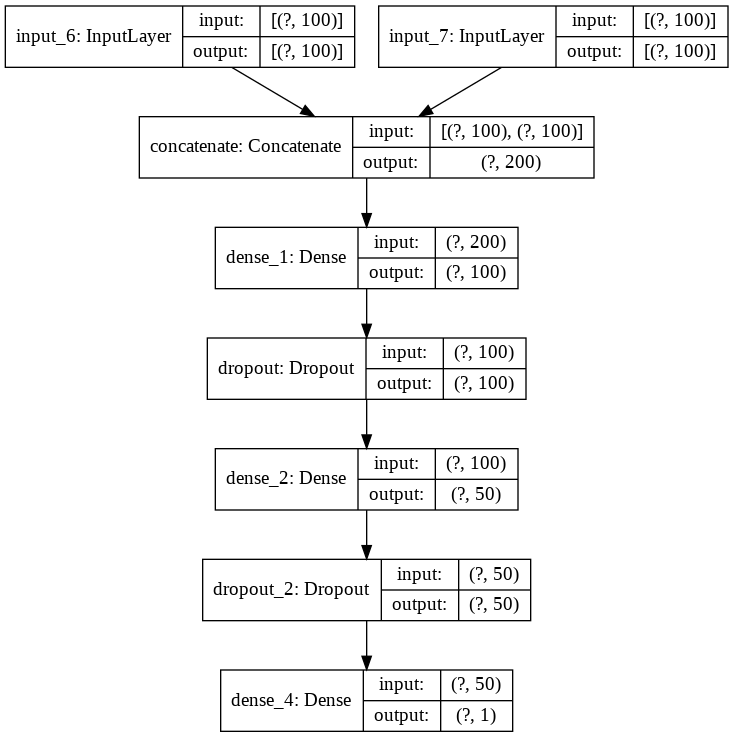

In [76]:
keras.utils.plot_model(binary_model,show_layer_names=True,show_shapes=True,to_file="binary_model.png")

#**FITTING models**

## **Fitting Seq2seq**

In [79]:
# decoder_targets_train_one_hot = np.zeros((
#         NUM_TRAIN,
#         pad_length_snippet,
#         num_words_output
#     ),
#     dtype='float32'
# )

# decoder_targets_test_one_hot = np.zeros((
#         NUM_TEST,
#         pad_length_snippet,
#         num_words_output
#     ),
#     dtype='float32'
# )

# decoder_targets_val_one_hot = np.zeros((
#         NUM_VAL,
#         pad_length_snippet,
#         num_words_output
#     ),
#     dtype='float32'
# )
decoder_sample_val_one_hot = np.zeros((3,pad_length_snippet,num_words_output),dtype='float32')

In [ ]:
for i, d in enumerate(train_padded_output_snippet_sequences):
    for t, word in enumerate(d):
      decoder_targets_train_one_hot[i, t, word] = 1

In [ ]:
for i, d in enumerate(test_padded_output_snippet_sequences):
    for t, word in enumerate(d):
        decoder_targets_test_one_hot[i, t, word] = 1

In [ ]:
for i, d in enumerate(val_padded_output_snippet_sequences):
    for t, word in enumerate(d):
      decoder_targets_val_one_hot[i, t, word] = 1

In [77]:
idx_word_intent = tok_intent.index_word
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [80]:
for i,d in enumerate(train_padded_output_snippet_sequences[:3][:]):
  for t, idx in enumerate(d):
    decoder_sample_val_one_hot[i,t,idx] = 1

In [81]:
sample_intent = train_padded_intent_sequences[:3][:]
sample_dec_input = train_padded_input_snippet_sequences[:3][:]
print(sample_intent.shape)
print(sample_dec_input.shape)

(3, 35)
(3, 635)


In [82]:
sample_intent[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 513,   2,  66,  49,   6,  73,  13,   1], dtype=int32)

In [83]:
reshape_intent = sample_intent.reshape((3,35))
reshape_intent.shape

(3, 35)

In [84]:
decoder_sample_val_one_hot.shape

(3, 635, 36212)

In [85]:
seq2seqmodel_history = model.fit(
          [reshape_intent,sample_dec_input],
          decoder_sample_val_one_hot,
          epochs=10,
          batch_size = 256
          )

Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 10.4977 - accuracy: 0.7879
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 10.4924 - accuracy: 0.9050
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 10.4869 - accuracy: 0.9197
Epoch 4/10
1/1 [==============================] - 0s 1ms/step - loss: 10.4805 - accuracy: 0.9365
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 10.4728 - accuracy: 0.9396
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 10.4632 - accuracy: 0.9423
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 10.4510 - accuracy: 0.9417
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - loss: 10.4349 - accuracy: 0.9402
Epoch 9/10
1/1 [==============================] - 0s 1ms/step - loss: 10.4129 - accuracy: 0.9407
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 10.3799 - accuracy: 0.9407


In [86]:
# getting the output from the seq2seq
# we are planning to get the word2vec embedding for the predicted code sequence from the seq2seq model
# we are adapting some of the stuff for a regular translation task

def code_generate(input_seq,_code_embedding_matrix = code_embedding_matrix):
  
    states_value = encoder_model.predict([input_seq])
    reshape_states_valueh = states_value[0][-1][:].reshape(1,-1) #just pass in the last hidden state
    reshape_states_valuec = states_value[1][-1][:].reshape(1,-1) #just pass in the last context state
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<START>']
    end_token = word2idx_outputs['<END>']
    output_sentence = []
    avg_embedding = np.zeros((EMBEDDING_SIZE,1),dtype='float32')

    for _ in range(pad_length_snippet):
        output_tokens, h, c = decoder_model.predict([target_seq,reshape_states_valueh,reshape_states_valuec])
        idx = np.argmax(output_tokens[0, 0, :])

        if end_token == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
            vector = _code_embedding_matrix[idx].reshape(-1,1)
            avg_embedding += vector
            

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence),avg_embedding/len(output_sentence)

In [88]:
with open('seq2seq_trainHistoryDict.pkl', 'wb') as file_pi:
  pickle.dump(seq2seqmodel_history.history, file_pi)

# serialize model to YAML
model_yaml = model.to_yaml()
with open("seq2seq_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("seq2seq_model.h5")
print("Saved model to disk")

Saved model to disk


## **Fitting on the binary model using the training samples**

In [89]:
def intent_w2v(sequence,_embedding_matrix = embedding_matrix):
  #embedding matrix: idx to vector mapping (it is a matrix)
  avg_embed = np.zeros((EMBEDDING_SIZE,1))
  num_nonzero = 0
  for token in sequence:
    if token != 0:
      vector = _embedding_matrix[token].reshape(-1,1)
      avg_embed += vector
      num_nonzero += 1
  
  return avg_embed/num_nonzero

In [90]:
#run it for all the 3 sets: train, test and val
intent_embeds = np.zeros((3,EMBEDDING_SIZE))
code_embeds = np.zeros((3,EMBEDDING_SIZE))
code_outputs = []
i = 0
for intent,dec_input in zip(reshape_intent,sample_dec_input):
  intent_embed = intent_w2v(intent)
  code_output,code_embed = code_generate(intent)
  print(i)
  code_embeds[i][:] = code_embed[:][0]
  code_outputs.append(code_output)
  intent_embeds[i][:] = intent_embed[:][0]
  i += 1

0
1
2


In [91]:
code_embeds.shape

(3, 100)

In [92]:
intent_embeds.shape

(3, 100)

In [93]:
type(code_embeds[0])

numpy.ndarray

In [94]:
# Need to apply this to the all the samples in the training sample set i had created earlier

#INPUTS TO THE BINARY MODEL
# INTENT W2V: avg W2V embedding for the intent sequence
# Code W2V/the average hidden state vector: the output of the Seq2seq model which needs to be applied 
# across all the samples in the training/val/test sets
'''
X: intent_embeds,code_embeds
y: the class label for the sample set working currently: y_train[:3]

'''
y_sample = y_train[:3]
bin_history = binary_model.fit(x = [intent_embeds,code_embeds],y = np.array(y_sample),epochs=10,batch_size=1)

Epoch 1/10
3/3 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 0.9297 - accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 0.5904 - accuracy: 0.6667
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 0.4478 - accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 0s 2ms/step - loss: 0.8005 - accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 0s 2ms/step - loss: 0.9099 - accuracy: 0.3333
Epoch 8/10
3/3 [==============================] - 0s 2ms/step - loss: 0.3010 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.6667
Epoch 10/10
3/3 [==============================] - 0s 2ms/step - loss: 0.3761 - accuracy: 1.0000


In [95]:
with open('binary_trainHistoryDict.pkl', 'wb') as file_pi:
  pickle.dump(bin_history.history, file_pi)

# serialize model to YAML
model_yaml = binary_model.to_yaml()
with open("binary_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("binary_model.h5")
print("Saved model to disk")

Saved model to disk


## **A sample test of the seq2seq alone**

In [162]:
sample_intent = test_padded_intent_sequences[0][:]
sample_dec_input = test_padded_input_snippet_sequences[0][:]
sample_dec_output = test_padded_output_snippet_sequences[0][:]
print(' '.join([idx_word_intent[idx] for idx in sample_intent if idx != 0]))
print(' '.join([idx2word_target[idx] for idx in sample_dec_input if idx != 0]))
print(' '.join([idx2word_target[idx] for idx in sample_dec_input if idx != 0]))

how to bind to all the number keys in tkinter
<START> headers = [ 'Name' , None , 'HW1' , 'HW2' , None , 'HW4' , 'EX1' , None , None ] for <VAR_NAME> in filter ( None , headers ) : print <VAR_NAME>
<START> headers = [ 'Name' , None , 'HW1' , 'HW2' , None , 'HW4' , 'EX1' , None , None ] for <VAR_NAME> in filter ( None , headers ) : print <VAR_NAME>


In [163]:
y_test[0]

0

In [172]:
code_output,avg_embed  =  code_generate(sample_intent)